# Cardiac agatston score computation

There are several variants of the metric. The code below computes metric slice by slice and reports total score.

Prerequisites:
- Install SegmentEditorExtraEffects extension
- Load CT data set
- Segment calcified regions using threshold effect
- Remove bones using Scissors effect
- Use Volume masking effect to blank out all voxels except the calcificaions in the selected vessel

Run this example in your browser using Binder: [![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/lassoan/SlicerNotebookDemos/master?filepath=CardiacAgatstonScoring.ipynb)

In [1]:
sampleDataSceneFile = slicer.app.temporaryPath+'/CardiacAgatstonSegmented.mrb'
slicer.util.downloadFile('https://github.com/lassoan/SlicerNotebooks/raw/master/data/CardiacAgatstonSegmented.mrb', sampleDataSceneFile)
slicer.util.loadScene(sampleDataSceneFile)

Requested file has been found: C:/Users/andra/AppData/Local/Temp/Slicer/CardiacAgatstonSegmented.mrb


## Original CT

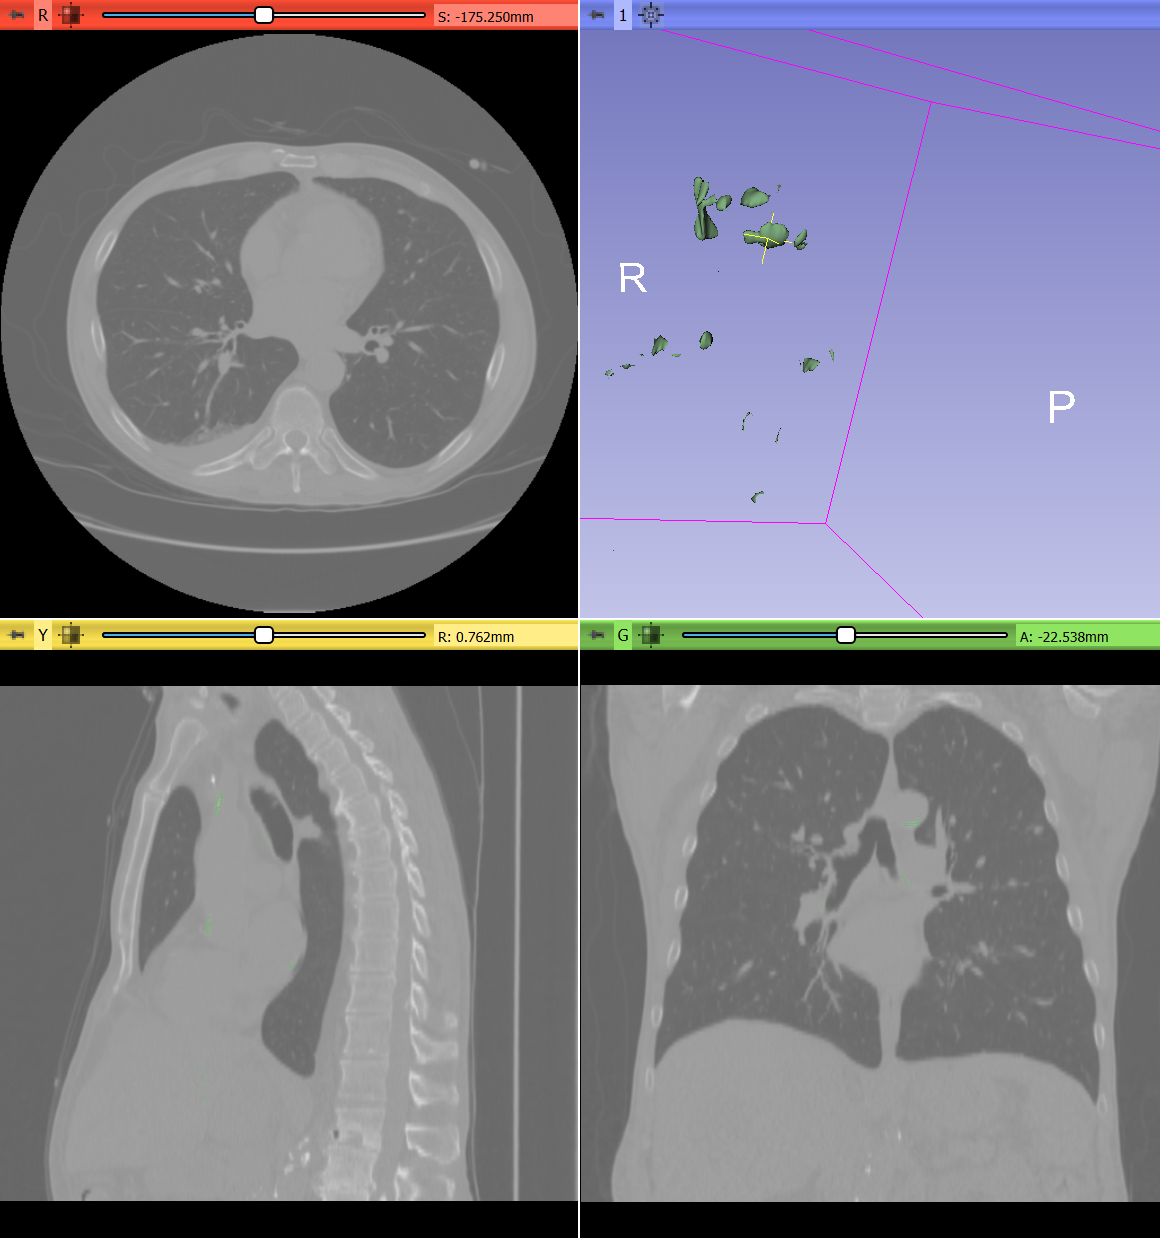

In [2]:
slicer.util.setSliceViewerLayers(background=getNode("CTChest"), fit=True)
display()

## Thresholded CT
In this example, all high-intensity objects are included, therefore computed score will be extremely high

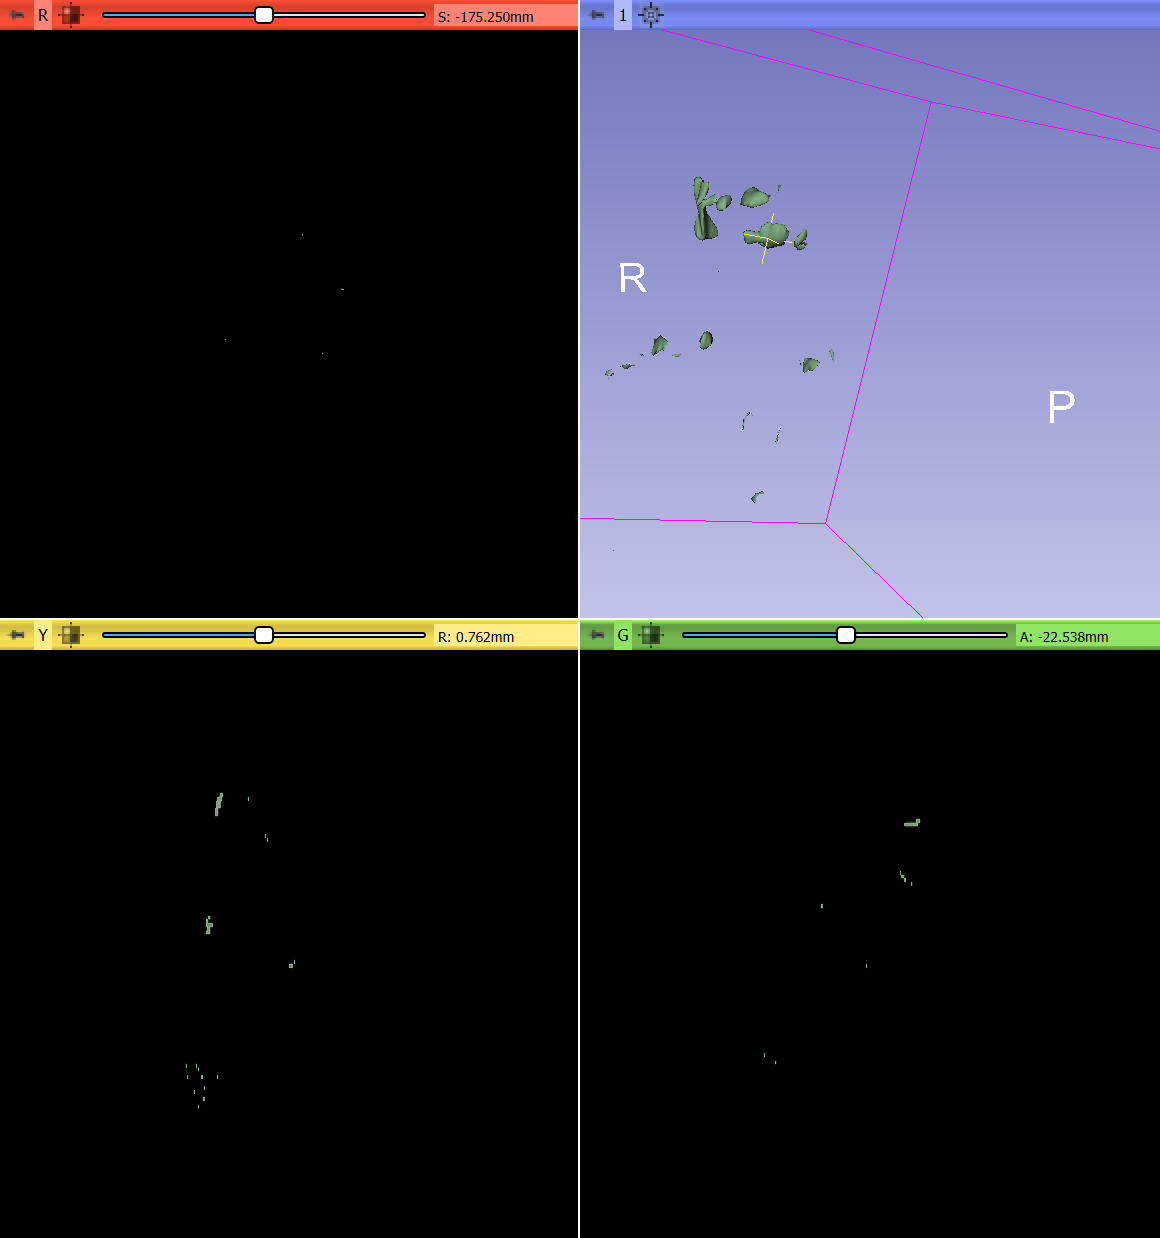

In [3]:
slicer.util.setSliceViewerLayers(background=getNode("CTChest masked"), fit=True)
display()

## Set inputs

In [9]:
volumeNode = getNode("CTChest masked")
verbose = False # Set it to True to print score for each slice
minimumIntensityThreshold = 130 # it to 130 (for 120 keV images) or 167 (for 80 keV images)
minimumIslandSizeInMm2 = 1.0

## Compute score

In [10]:
import numpy as np
import math
import SimpleITK as sitk

voxelArray = slicer.util.arrayFromVolume(volumeNode)
areaOfPixelMm2 = volumeNode.GetSpacing()[0] * volumeNode.GetSpacing()[1]
minimumIslandSizeInPixels = int(round(minimumIslandSizeInMm2/areaOfPixelMm2))
numberOfSlices = voxelArray.shape[0]
totalScore = 0

for sliceIndex in range(numberOfSlices):
    # Get a single image slice
    voxelArraySlice = voxelArray[sliceIndex]
    maxIntensity = voxelArraySlice.max()
    if maxIntensity < minimumIntensityThreshold:
        continue

    # Get a thresholded image to analyse connected components (islands)
    # All islands that are smaller than minimumIslandSizeInPixels will be
    # considered as noise and will be discarded.
    thresholdedVoxelArraySlice = voxelArraySlice>minimumIntensityThreshold
    sliceImage = sitk.GetImageFromArray(voxelArraySlice)
    thresholdedSliceImage = sitk.GetImageFromArray(thresholdedVoxelArraySlice.astype(int))
    labelImage = sitk.ConnectedComponentImageFilter().Execute(thresholdedSliceImage)
    stats = sitk.LabelStatisticsImageFilter()
    stats.Execute(sliceImage, labelImage)

    numberOfNonZeroVoxels = 0
    numberOfIslands = 0
    sliceScore = 0
    for labelIndex in stats.GetLabels():
        if labelIndex == 0:
            continue
        if stats.GetCount(labelIndex) < minimumIslandSizeInPixels:
            continue
        maxIntensity = stats.GetMaximum(labelIndex)
        weightFactor = math.floor(maxIntensity/100)
        if weightFactor > 4:
            weightFactor = 4.0
        numberOfNonZeroVoxelsInIsland = stats.GetCount(labelIndex)
        sliceScore += numberOfNonZeroVoxelsInIsland * areaOfPixelMm2 * weightFactor
        numberOfNonZeroVoxels += numberOfNonZeroVoxelsInIsland
        numberOfIslands += 1

    totalScore += sliceScore        
    if (sliceScore > 0) and verbose:
        print("Slice {0} score: {1:.1f} (from {2} islands of size > {3}, total of {4} voxels)".format(
            sliceIndex, sliceScore, numberOfIslands, minimumIslandSizeInPixels,
            numberOfNonZeroVoxels))
        slicer.app.processEvents()

print("Total Agatston score: {0}".format(totalScore))

Total Agatston score: 6590.09125309
